In [1]:
import os
import re
import csv
import datetime

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import cv2 as cv

from torch.nn.utils.spectral_norm import spectral_norm

import torch.optim as optim

from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, Subset
from torchvision.io import read_image
from torchvision.transforms import Grayscale, Resize, InterpolationMode

from torchmetrics.image.fid import FrechetInceptionDistance
import torch_fidelity
import random


In [2]:

def preprocess_lines(data_root):
    """
    Creates a new `.txt` file `lines_improved.txt` that will be used
    for querying
    """
    original_path = os.path.join(data_root, "lines.txt")
    improved_path = os.path.join(data_root, "lines_improved.txt")
    fi = open(improved_path, "w")

    # Some variables for tracking
    num_samples = 0
    valid_samples = 0
    
    # Loop through "lines.txt"
    with open(original_path, "r") as fo:
        # TODO replace imag_path with the .pt file later on
        headers = ["image_id", "image_path", "image_pt_path", "graylevel", "original_height", "original_width", "transcription", "transcription_len"]
        fi.writelines("\t".join(headers) + "\n")

        # Skip the intro stuff
        for line in fo.readlines():
            if line.startswith("#"):
                continue

            # Valid lines, not the intro_text
            line_items = line.strip().split(" ")  # `strip()` to remove newlines

            # The actua items (we extract the important ones)
            image_id = line_items[0]
            status = line_items[1]
            graylevel = int(line_items[2])
            transcription = " ".join(line_items[8:])  # Some data has whitespace

            # Skip error images
            if status == "err":
                continue
        
            # Alphanumeric + common punctuation regex
            # Returns None if no match
            # 26 + 26 + 10 + 9 + 1 = 72
            # Spaces might be included as well
            if re.fullmatch("[a-zA-Z0-9.!?'\",:;| -]*", transcription) is None:
                continue

            # Now we have valid transcription
            # We get the `.png` image path
            inp = image_id.split("-")  # `inp` stands for image name parts
            image_path_head = os.path.join(data_root, "lines", inp[0], f"{inp[0]}-{inp[1]}")
            image_path_tail = f"{image_id}.png"
            image_path = os.path.join(image_path_head, image_path_tail)
            num_samples += 1
            tmp_image = read_image(os.path.join(image_path_head, image_path_tail))  # Temporarily reading to get dimensions
            _, height, width = tmp_image.shape

            # Scaling calculations
            # If width * scale >= desired length (>= to be safe)
            if width * (32/height) >= 512:
                continue

            resized_tensor = process_image_tensor(tmp_image, graylevel)
            image_pt_path = os.path.join(image_path_head, f"{image_id}.pt")
            torch.save(resized_tensor, image_pt_path)

            # A fully valid image
            # Separate by underscores because `transcription` has spaces so we can't split by spaces
            fi.writelines(f"{image_id}\t{image_path}\t{image_pt_path}\t{graylevel}\t{height}\t{width}\t{transcription}\t{len(transcription)}\n")
            valid_samples += 1
        
        fi.close()
    
    print("# samples:", num_samples)
    print("Valid samples:", valid_samples)


def process_image_tensor(image_tensor, graylevel):
    """
    Returns a copy of image_tensor, processed (doesn't update the original variable)
    """

    # Grayscale the image - if the image is not already in grayscale
    grayscale_transform = Grayscale()
    image_tensor = grayscale_transform(image_tensor)

    # Resize it
    resize_transform = Resize(32, InterpolationMode.NEAREST_EXACT)
    image_tensor = resize_transform(image_tensor)

    # Threshold it
    # Threshold first because threshold was specifically specified for the original
    image_tensor = image_tensor >= graylevel

    # Add padding
    _,_, resized_height = image_tensor.shape
    padding_to_add = 512 - resized_height
    image_tensor = F.pad(image_tensor, (0, padding_to_add), value=1)

    # Convert to uint8
    image_tensor = image_tensor.type(torch.float32)

    return image_tensor

# Uncomment this if your data isn't processed yet
preprocess_lines("./data/")

# samples: 11073
Valid samples: 7135


In [3]:
# Sorted by ascii code
valid = [
    ' ', '!', '"', "'", ',', '-', '.',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
    ':', ';', '?', 
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
]
# Enumerate from 1 to save space for padding
char_to_int = {v: i for i, v in enumerate(valid, 1)}
int_to_char = {i: v for i, v in enumerate(valid, 1)}

In [5]:
class LineDataset(Dataset):
    def __init__(self, lines_improved_dir, ty=None):
        """
        params:
            lines_improved_dir: path to the `lines_improved.txt` file
            ty: type of the dataset "txt", "img" for text dataset or image dataset.
        """
        self.lines_df = pd.read_csv(lines_improved_dir, sep="\t", quoting=csv.QUOTE_NONE)  # List containing the stuff in `lines.txt`
        length = self.lines_df.shape[0]
        self.max_transcription_len = max(self.lines_df["transcription_len"])
        self.ty = ty
        line_datas = self.lines_df.iloc
        ret_texts = [line_datas[i]['transcription'].replace('|', ' ') for i in range(length)]
        ret_ctois = [torch.tensor([char_to_int[char] for char in ret_texts[i]]) for i in range(length)]
        self.ret_ctoi_paddeds = [F.pad(ret_ctois[i], pad=(0, self.max_transcription_len-len(ret_ctois[i]))) for i in range(length)]
        self.ret_images = [torch.load(line_datas[i]["image_pt_path"]) for i in range(length)]
    def __len__(self):
        return len(self.lines_df)
    
    def __getitem__(self, index):
        # line_data = self.lines_df.iloc[index]

        # ret_text = line_data['transcription'].replace('|', ' ')
        # # Get the numerical mapping
        # ret_ctoi = torch.tensor([char_to_int[char] for char in ret_text])
        # # Padding to the left amount to make it reach `max_transcription_len`
        # # TODO possibility to remove padding in the future and let a dataloader handle it
        # ret_ctoi_padded = F.pad(ret_ctoi, pad=(0, self.max_transcription_len-len(ret_ctoi)))
        # ret_image = torch.load(line_data["image_pt_path"])

        # Different type of individual loaders
        if self.ty == "txt":
            return self.ret_ctoi_paddeds[index]
        elif self.ty == "img":
            return self.ret_images[index]
        else:
            return self.ret_images[index], self.ret_ctoi_paddeds[index]

In [64]:
line_transcription_dataset = LineDataset("./data/lines_improved.txt", ty="txt")
line_image_dataset = LineDataset("./data/lines_improved.txt", ty="img")
line_dataset = LineDataset("./data/lines_improved.txt")

# Don't change this, we want to maintain consistent split
torch.manual_seed(12345678)  # DO NOT REMOVE THIS LINE
line_transcription_dataset_train, line_transcription_dataset_val = random_split(line_transcription_dataset, [0.8, 0.2])
line_image_dataset_train, line_image_dataset_val = random_split(line_image_dataset, [0.8, 0.2])
line_dataset_train, line_dataset_val = random_split(line_dataset, [0.8, 0.2])

# To train on a small dataset
line_transcription_dataset_train = Subset(line_transcription_dataset_train, range(100))
line_transcription_dataset_val = Subset(line_transcription_dataset_val, range(20))

line_image_dataset_train = Subset(line_image_dataset_train, range(1000))
line_image_dataset_val = Subset(line_image_dataset_val, range(20))

# line_transcription_dataset_train, line_transcription_dataset_val, _ = random_split(line_transcription_dataset, [0.005, 0.005, 0.99])
# line_image_dataset_train, line_image_dataset_val, _ = random_split(line_image_dataset, [0.005, 0.005, 0.99])
# line_dataset_train, line_dataset_val = random_split(line_dataset, [0.0025, 0.9975])

print("lines")
print(len(line_transcription_dataset_train), len(line_transcription_dataset_val))
print("images")
print(len(line_image_dataset_train), len(line_image_dataset_val))
print("both")
print(len(line_dataset_train), len(line_dataset_val))

lines
100 20
images
1000 20
both
5708 1427


In [7]:
a = iter(line_image_dataset_train)
import pytesseract
import numpy as np
from PIL import Image
import torchvision.transforms as T
itransform = T.ToPILImage()

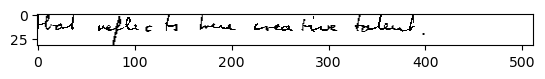

In [8]:
plt.figure()
img = itransform(next(a).squeeze(0))
plt.imshow(img, cmap="gray")

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fid = FrechetInceptionDistance(feature=2048)
fid.to(device)
device

device(type='cuda')

In [48]:
len(line_image_dataset_val)

20

In [65]:
test_loader1 = DataLoader(line_image_dataset_train, batch_size=20, shuffle=True)
test_loader2 = DataLoader(line_image_dataset_val, batch_size=20, shuffle=True)
# ii = next(iter(test_loader2))
ii = torch.load("./h")
# print(type(ii))
# print(ii[0])
a = 0
# print(ii.shape)
for iii, i in enumerate(test_loader1, start=1):
    # print(torch.isinf((i.cpu()*255).to(torch.uint8).repeat(1, 3, 1, 1)).any())
    print(i.shape)
    fid.update((i*255).to(torch.uint8).repeat(1, 3, 1, 1).to(device), real=True)
    # fid.update((ii.cpu()*255).to(torch.uint8).repeat(1, 3, 1, 1).to(device), real=False)
    fid.update((ii).to(torch.uint8).repeat(1, 3, 1, 1).to(device), real=False)
        
    f = fid.compute()
    a += f
    fid.reset()
print(a/iii)

torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20, 1, 32, 512])
torch.Size([20